In [76]:
%%time

#Kaggle Competition:  https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


%matplotlib inline
pd.options.display.max_rows = 3000


import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


def data_cleansing(df):
    print('\n    Step: Cleaning Data / Removing Fare and Location outliers')
    #define boundaries for new york city and surrounding area
    lat_min = 10 #40.68
    lat_max = 50 #40.836

    lon_min = -90 #-74.025
    lon_max = 0 #-73.92

    #df = df.loc[df.passenger_count < 10]
    #df = df.loc[df.fare_amount < 100]
    df = df.loc[df.fare_amount > 0]

    df = df.loc[(df.pickup_latitude >= lat_min) & (df.pickup_latitude < lat_max)]
    df = df.loc[(df.dropoff_latitude >= lat_min) & (df.dropoff_latitude < lat_max)]

    df = df.loc[(df.pickup_longitude >= lon_min) &  (df.pickup_longitude <= lon_max)]
    df = df.loc[(df.dropoff_longitude >= lon_min) &  (df.dropoff_longitude <= lon_max)]

    return df

def data_cleansing2(df):
    print('\n    Step: Cleaning Data / Removing Distance outliners')
    df = df[df.Distance > .005]
    df['farepermile'] = df.fare_amount / df.Distance
    df = df[df.farepermile > .3]
    df = df[df.farepermile < 120]
    return df
    

def feature_engineering_apply_dates(df):
    print('    Step: Feature Engineering- Applying Dates')    
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day_of_week'] = df['pickup_datetime'].dt.day_name()
    df['month'] = df['pickup_datetime'].dt.month_name()
    df['year'] = df['pickup_datetime'].dt.year
    df['year'] = 2015 - df['year']
    df.rename(columns={'year' : 'yearsback'}, inplace=True)  #Rename Col A to be called Col B

    df['hour'] = np.where( (df.hour < 7) | (df.hour > 23), 'offhours',df.hour)
    df['hour'] = 'hour ' + df.hour.apply(str)
    
    #create dummies for each hour bin
    dummies = pd.get_dummies(df.hour)
    df = pd.concat([df, dummies], axis=1)

    #create dummies for each day of week
    dummies = pd.get_dummies(df.day_of_week)
    df = pd.concat([df, dummies], axis=1)

    #create dummies for each month
    dummies = pd.get_dummies(df.month)
    df = pd.concat([df, dummies], axis=1)
    return df
     
def feature_engineering_apply_distance(df):
    print('    Step: Feature Engineering- Calculating Distances')
    import geopy.distance 
    def calc_distance(x):
        #print(x)
        coords_1 = tuple([x.pickup_latitude, x.pickup_longitude])
        coords_2 = tuple([x.dropoff_latitude, x.dropoff_longitude])
        d = geopy.distance.vincenty(coords_1, coords_2).miles 
        #print(d)
        return d

    df['Distance'] = df.apply(calc_distance, axis=1)  

    return df


def get_neighborhood_clusters(df, num_clusters):
    print('    Step: Feature Engineering- Running KMeans to get neighborhood clusters')
    df_pickup = df[['pickup_latitude','pickup_longitude']]
    df_dropoff = df[['dropoff_latitude','dropoff_longitude']]
    df_pickup.columns = ['lat','lon']
    df_dropoff.columns = ['lat','lon']

    df_neighborhood = pd.concat([df_pickup, df_dropoff], axis=0, names=['lat','lon'], 
                                sort=True, ignore_index=True)

    df_neighborhood.drop_duplicates(inplace=True)

    dict_neighborhoods ={
      0: 'a',
      1: 'b',
      2: 'c',
      3: 'd',
      4: 'e',
      5: 'f',
      6: 'g',
      7: 'h',
      8: 'i',
      9: 'j',
      10: 'k',
      11: 'l',
      12: 'm',
      13: 'n',
      14: 'o',
      15: 'p'
    }

    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_jobs=-1)
    kmeans.fit(df_neighborhood)

    neighborhood = kmeans.predict(df_neighborhood) 

    df_neighborhood['neighborhood'] = neighborhood
    df_neighborhood['neighborhood'] = df_neighborhood['neighborhood'].map(dict_neighborhoods)

    return df_neighborhood


def feature_engineering_apply_neighborhoods(df, df_neighborhood):

    print('    Step: Feature Engineering- Applying neighborhoods to data')
    df_neighborhood_pickup = df_neighborhood.copy()
    df_neighborhood_dropoff = df_neighborhood.copy()
    df_neighborhood_pickup['pickup_neighborhood'] = 'pickup_' + df_neighborhood_pickup.neighborhood
    df_neighborhood_dropoff['dropoff_neighborhood'] = 'dropoff_' + df_neighborhood_dropoff.neighborhood
    df_neighborhood_pickup.drop(columns=['neighborhood'], axis=1, inplace=True)
    df_neighborhood_dropoff.drop(columns=['neighborhood'], axis=1, inplace=True)


    df = pd.merge(df, df_neighborhood_pickup, how='left', 
                         left_on = [df.pickup_latitude, df.pickup_longitude], 
                         right_on = [df_neighborhood_pickup.lat, df_neighborhood_pickup.lon])


    df.drop(columns=['key_0','key_1','lat','lon'], axis=1, inplace=True)



    df = pd.merge(df, df_neighborhood_dropoff, how='left', 
                         left_on = [df.dropoff_latitude, df.dropoff_longitude],
                         right_on = [df_neighborhood_dropoff.lat, df_neighborhood_dropoff.lon] )

    df.drop(columns=['key_0','key_1','lat','lon'], axis=1, inplace=True)

    #df['pickup_dropoff'] =  df.pickup_neighborhood.apply(str) + '_' + df.dropoff_neighborhood.apply(str)
    ###df['to_from'] =  df.pickup_neighborhood.apply(str) + '_' + df.dropoff_neighborhood.apply(str)
    ###df['from_to'] =  df.dropoff_neighborhood.apply(str) + '_' + df.pickup_neighborhood.apply(str)
    ###df['pickup_dropoff'] = np.where(df.to_from > df.from_to, df.from_to, df.to_from)

    ####create dummies for pickup_dropoff combo
    ###dummies = pd.get_dummies(df.pickup_dropoff)
    ###df = pd.concat([df, dummies], axis=1)
    ###df.drop(columns=['from_to','to_from'],inplace=True)

    #create dummies for pickup neighborhood
    dummies = pd.get_dummies(df.pickup_neighborhood)
    df = pd.concat([df, dummies], axis=1)

    #create dummies for dropoff neighborhood
    dummies = pd.get_dummies(df.dropoff_neighborhood)
    df = pd.concat([df, dummies], axis=1)

    return df




CPU times: user 1.96 ms, sys: 1.72 ms, total: 3.68 ms
Wall time: 14.7 ms
Parser   : 338 ms


In [3]:
%%time
raw_data = pd.read_csv('train.csv')
#test_data = pd.read_csv('test.csv')
print(raw_data.shape)

(55423856, 8)
CPU times: user 1min 52s, sys: 47.9 s, total: 2min 40s
Wall time: 2min 59s


In [269]:
%%time

##Main Processing Step

#take a sample of the raw data
df = raw_data.sample(n=100000, random_state = 15)

print('Shape Before Pre-Processing: ' + str(df.shape))

# ---- Data Cleansing ------
df = data_cleansing(df)

# -----Perform Feature Engineering------
#Call functions to:
#   parse pickup_datetime into year, month, day of week, hour
#   calculate distance between pickup location and dropoff location
df = feature_engineering_apply_dates(df)
df = feature_engineering_apply_distance(df)

# ---- More Data Cleansing ------
df = data_cleansing2(df)

#Call function to classify each pickup and dropoff location into a neighborhood
neighborhoods = get_neighborhood_clusters(df, 10)

#label data with pickup and dropoff neighborhood
df = feature_engineering_apply_neighborhoods(df, neighborhoods)

#split training data into X features and y target
y = df.fare_amount
X = df.drop(columns=['fare_amount']) #remove target from X 

#remove non-numeric descriptive variables
X = X.drop(columns=['day_of_week','hour',
                     'pickup_latitude','pickup_longitude',
                     'dropoff_latitude','dropoff_longitude','key',
                    'pickup_neighborhood','dropoff_neighborhood',
                     'month','passenger_count',
                    'pickup_datetime', 'farepermile'])  

#split dataset into train .70 and test .30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=20)

#now split the test dataset into 2 test sets
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, 
                                                    random_state=20)

print('\nShape After Pre-Processing: ' + str(df.shape) + '\n')

Shape Before Pre-Processing: (100000, 8)

    Step: Cleaning Data / Removing Fare and Location outliers
    Step: Feature Engineering- Applying Dates
    Step: Feature Engineering- Calculating Distances

    Step: Cleaning Data / Removing Distance outliners
    Step: Feature Engineering- Running KMeans to get neighborhood clusters


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


    Step: Feature Engineering- Applying neighborhoods to data

Shape After Pre-Processing: (96205, 73)

CPU times: user 43.5 s, sys: 5.95 s, total: 49.4 s
Wall time: 1min 8s


In [287]:
%%time
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_train[['Distance', 'yearsback']], y_train)

# Inspect the results.
print('---- Baseline Regression ----')


#Load results into a df to display
results_df = pd.DataFrame({'Parameter': ['Distance', 'yearsback'], 
                 'Coeffecient' : regr.coef_})

print('Intercept ' + str(regr.intercept_) + '\n')
print(results_df)

print('\nTrain R-squared: ' + str(regr.score(X_train[['Distance', 'yearsback']], y_train)))
print('Test#1 R-squared: ' + str(regr.score(X_test1[['Distance', 'yearsback']], y_test1)))
print('Test#2 R-squared: ' + str(regr.score(X_test2[['Distance', 'yearsback']], y_test2)))

---- Baseline Regression ----
Intercept 5.900565980033052

   Parameter  Coeffecient
0   Distance     3.374481
1  yearsback    -0.533039

Train R-squared: 0.7469576912416331
Test#1 R-squared: 0.7866675978301052
Test#2 R-squared: 0.7427009001447802
CPU times: user 20.1 ms, sys: 7.86 ms, total: 28 ms
Wall time: 196 ms


In [286]:
%%time

#----- Model: Lasso Linear Regression  ------------
from sklearn import linear_model

clf = linear_model.Ridge(alpha=1000)
clf.fit(X_train, y_train)

print('Training Accuracy: ' + str(clf.score(X_train,y_train)))
print('Testing Accuracy #1: ' + str(clf.score(X_test1,y_test1)))
print('Testing Accuracy #2: ' + str(clf.score(X_test2,y_test2)) + '\n')

print('Intercept' + str(clf.intercept_))  

results = np.stack([X_train.columns, clf.coef_])
results = pd.DataFrame(results.transpose())
results.columns = ['Parameter','Coeffecient']
results['abs'] = np.abs(results.Coeffecient)
print(results.sort_values(by='abs', ascending=False))

Training Accuracy: 0.7663475629181452
Testing Accuracy #1: 0.7964298041991136
Testing Accuracy #2: 0.7638153434252322

Intercept7.605474250342171
        Parameter Coeffecient         abs
38       Distance     3.18766     3.18766
44       pickup_f     2.72567     2.72567
43       pickup_e     1.80419     1.80419
54      dropoff_f      1.7397      1.7397
49      dropoff_a    -1.24568     1.24568
53      dropoff_e     1.16563     1.16563
52      dropoff_d    -1.16297     1.16297
47       pickup_i    -0.93435     0.93435
46       pickup_h   -0.843274    0.843274
42       pickup_d   -0.802747    0.802747
18  hour offhours   -0.796381    0.796381
45       pickup_g   -0.700399    0.700399
51      dropoff_c    0.669987    0.669987
39       pickup_a   -0.639254    0.639254
41       pickup_c    -0.56551     0.56551
0       yearsback   -0.539557    0.539557
55      dropoff_g   -0.509957    0.509957
13        hour 22   -0.473082    0.473082
57      dropoff_i   -0.447837    0.447837
5         hour

In [228]:
%%time
#----- Model: K Nearest Neighbors Regression ------------
from sklearn import neighbors 

knn = neighbors.KNeighborsRegressor(n_neighbors=15, n_jobs=-1 )
knn.fit(X_train, y_train)
print('Training Accuracy: ' + str(knn.score(X_train,y_train)))
##print('Testing #1 Accuracy: ' + str(knn.score(X_test1,y_test1)))
##print('Testing #2 Accuracy: ' + str(knn.score(X_test2,y_test2)))
print('')


Training Accuracy: 0.8692500412771645

CPU times: user 1h 40min 43s, sys: 31.1 s, total: 1h 41min 14s
Wall time: 27min 20s


In [281]:
from sklearn.model_selection import cross_val_score
cv=5

#Ridge
score = cross_val_score(clf, X, y, cv=cv)
print("\nRidge Regr- Cross Validation Accuracy %i folds: %.3f (+/- %.3f)" % (cv, score.mean(), (score.std() * 2)))





Ridge Regr- Cross Validation Accuracy 5 folds: 0.769 (+/- 0.049)


In [105]:
#Perform Cross Validation on all models
from sklearn.model_selection import cross_val_score
cv=5

#Baseline Regression
score = cross_val_score(regr, X[['Distance','yearsback']], y, cv=cv)
print("\nBaseline Regression- Cross Validation Accuracy %i folds: %.3f (+/- %.3f)" % (cv, score.mean(), (score.std() * 2)))

#Ridge
score = cross_val_score(clf, X, y, cv=cv)
print("\nRidge Regr- Cross Validation Accuracy %i folds: %.3f (+/- %.3f)" % (cv, score.mean(), (score.std() * 2)))

#knn
score = cross_val_score(knn, X, y, cv=cv)
print("\nKNN- Cross Validation Accuracy %i folds: %.3f (+/- %.3f)" % (cv, score.mean(), (score.std() * 2)))


Baseline Regression- Cross Validation Accuracy 5 folds: 0.751 (+/- 0.055)


Lasso Regr- Cross Validation Accuracy Lasso 5 folds: 0.793 (+/- 0.053)

KNN- Cross Validation Accuracy 5 folds: 0.843 (+/- 0.012)


In [112]:
#Run grid search to find the optimal nearest neighbor parameters

%%time 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors

Ks = [10,15]
param_grid = {'n_neighbors': Ks}
grid_search = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv=5,
                  return_train_score=False)
grid_search.fit(X, y)
#grid_search.best_params_

CPU times: user 15min 15s, sys: 900 ms, total: 15min 16s
Wall time: 17min 34s


In [116]:
#view Gridsearch results
pd.DataFrame(grid_search.cv_results_).transpose()

,0,1,2
mean_fit_time,0.67365,0.667808,0.666834
std_fit_time,0.0213522,0.0176359,0.017522
mean_score_time,57.0537,60.6025,90.8924
std_score_time,0.0620982,0.0635385,55.2393
param_n_neighbors,20,30,40
params,{'n_neighbors': 20},{'n_neighbors': 30},{'n_neighbors': 40}
split0_test_score,0.858085,0.85555,0.854386
split1_test_score,0.845153,0.843826,0.84231
split2_test_score,0.84511,0.84547,0.843836
split3_test_score,0.839211,0.838003,0.837161


In [68]:
#T Test on KNN Model vs baseline model
import scipy.stats as stats

pred_knn = knn.predict(X_train)
pred_baseline_regr = regr.predict(X_train[['Distance','yearsback']])

#this returns a tuple (tval, pval)
tval, pval = stats.ttest_ind(pred_knn, pred_baseline_regr, equal_var=False)  
print('tval: ' + str(tval))
print('pval: ' + str(pval)

if pval < .05:
         r = 'reject null'
else:
         r = 'accept null (no difference)'

print(r)

-4.323688361478397
1.5355193000346605e-05


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


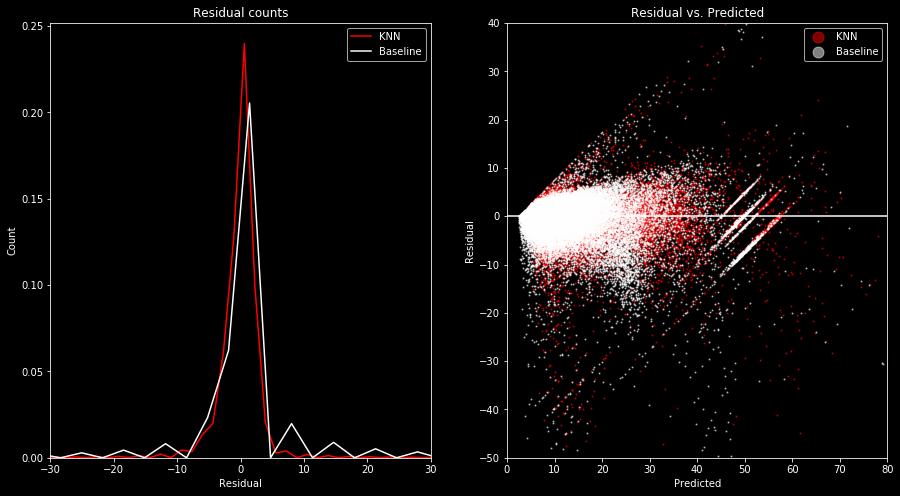

In [71]:
#Visualize Residuals for KNN model vs Baseline Model

knn_residuals = pred_knn - y_train
baseline_residuals = pred_baseline_regr - y_train

fig = plt.figure(figsize=(15,8))

# Calculate the error, also called the residual.

fig.add_subplot(121)
plt.xlim(-30,30)
sns.distplot(knn_residuals, color='red', label='KNN', hist=False, norm_hist=False)
sns.distplot(baseline_residuals, color='white', label='Baseline', hist=False, norm_hist=False)
#plt.hist(knn_residuals, bins=200, color='red', alpha=.4, label='KNN')
#plt.hist(baseline_residuals, bins=200, color='white', alpha=.4, label='Baseline')
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.legend(loc = 'upper right')

fig.add_subplot(122)
plt.ylim(-50,40)
plt.xlim(0,80)
plt.scatter(pred_knn, knn_residuals, s=1.2, alpha=.5, color='red', label='KNN')
plt.scatter(pred_baseline_regr, baseline_residuals, s=1.2, alpha=.5, color='white', label='Baseline')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.legend(loc = 'upper right', markerscale=10)

plt.show()


Text(0,0.5,'Longitude')

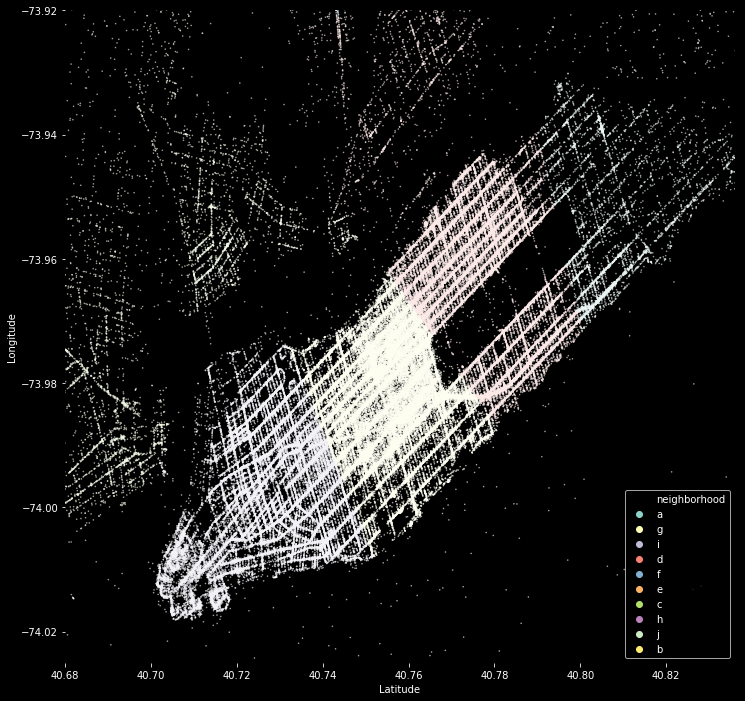

In [128]:
#Plot trips forming a map of NYC

lat_min = 40.68
lat_max = 40.836

lon_min = -74.025
lon_max = -73.92


plt.style.use('dark_background')

# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset

f, ax = plt.subplots(figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

plt.xlim(lat_min,lat_max)
plt.ylim(lon_min,lon_max)
#palette='RdGy',
sns.scatterplot(x="lat", y="lon", 
                hue="neighborhood", 
                data=neighborhoods, alpha=.5, s=.8)
plt.xlabel('Latitude')
plt.ylabel('Longitude')

<function matplotlib.pyplot.show(*args, **kw)>

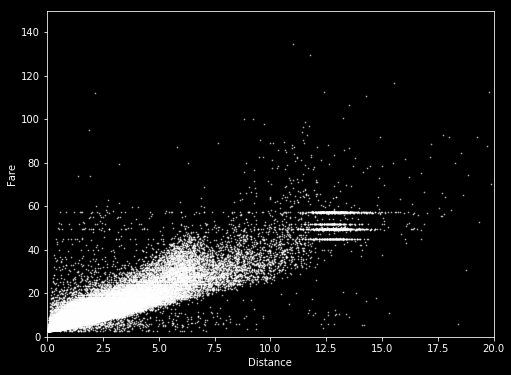

In [75]:
plt.style.use('dark_background')
plt.subplots(figsize=(8, 6))
plt.ylim(0,150)
plt.xlim(0,20)
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.scatter(df.Distance, df.fare_amount, s=.5, alpha=.6, color='white')
plt.show

In [ ]:
# Boxplots of features
plt.style.use('dark_background')
plt.subplots(6, 1, sharey=False, sharex=False , figsize=(15,8))

i = 1
for column in df[['pickup_latitude','pickup_longitude','dropoff_latitude',
                  'dropoff_longitude','fare_amount']].columns:
    plt.subplot(2,3,i)
    sns.boxplot(df[column])
    i = i + 1


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


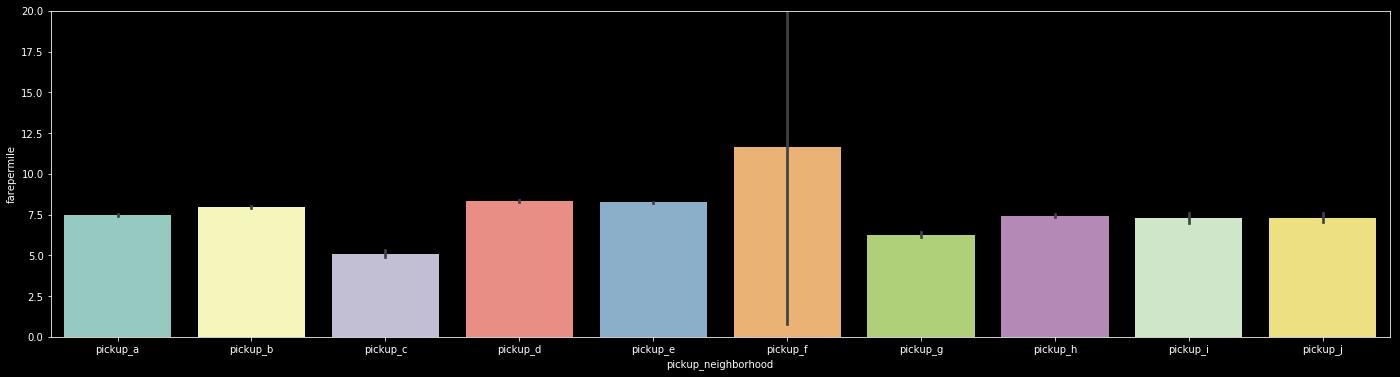

In [45]:
df = df.sort_values(by='pickup_neighborhood')
from numpy import mean
plt.style.use('dark_background')
plt.subplots(figsize=(24, 6))
plt.ylim(0,20)
sns.barplot(x='pickup_neighborhood', y='farepermile', data=df, estimator=mean)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


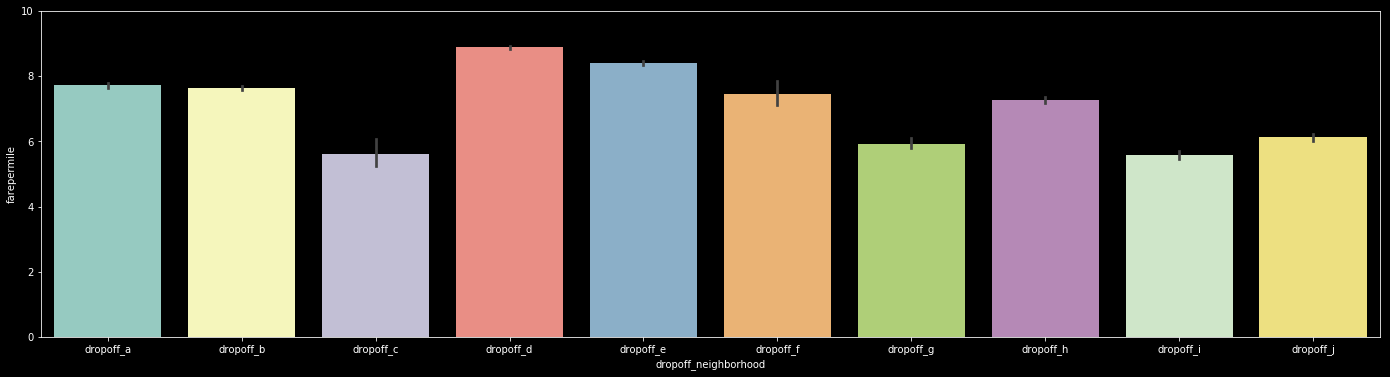

In [46]:
df = df.sort_values(by='dropoff_neighborhood')
from numpy import mean
plt.style.use('dark_background')
plt.subplots(figsize=(24, 6))
plt.ylim(0,10)
sns.barplot(x='dropoff_neighborhood', y='farepermile', data=df, estimator=mean)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


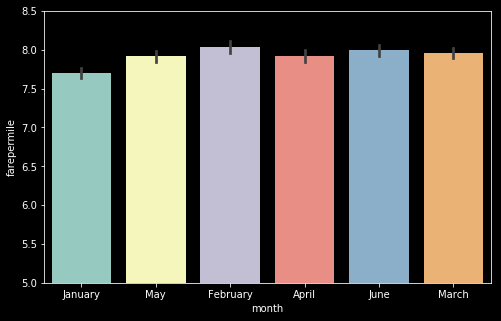

In [48]:
from numpy import mean
#df = df.sort_values(by='month', ascending=False)
plt.style.use('dark_background')
plt.subplots(figsize=(8, 5))
plt.ylim(5,8.5)
sns.barplot(x='month', y='farepermile', data=df, estimator=mean)

In [198]:
#functions necessary to run new data through the model.  And for Kaggle submission.

def apply_neighborhoods_to_test_data(testdf, neighborhoods):

    model_neighborhoods = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    X_neighborhoods = neighborhoods[['lat','lon']]
    y_neighborhoods = neighborhoods[['neighborhood']]
    model_neighborhoods.fit(X_neighborhoods, y_neighborhoods)
    print('Accuracy: ' + str(model_neighborhoods.score(X_neighborhoods,y_neighborhoods)))

    #Get pickup_neighborhood
    pickup_neighborhood = model_neighborhoods.predict(testdf[['pickup_latitude', 
                                                              'pickup_longitude']])


    #Get dropoff_neighborhood
    dropoff_neighborhood = model_neighborhoods.predict(testdf[['dropoff_latitude', 
                                                              'dropoff_longitude']])

    #apply to dataframe
    testdf['pickup_neighborhood'] = 'pickup_' + pickup_neighborhood
    testdf['dropoff_neighborhood'] = 'dropoff_' + dropoff_neighborhood

    #create dummies for pickup neighborhood
    dummies = pd.get_dummies(testdf.pickup_neighborhood)
    testdf = pd.concat([testdf, dummies], axis=1)

    #create dummies for dropoff neighborhood
    dummies = pd.get_dummies(testdf.dropoff_neighborhood)
    testdf = pd.concat([testdf, dummies], axis=1)
    
    return testdf

def insert_missing_columns(df, df_to_match):

    expected_cols = df_to_match.columns
    complete=False

    while complete==False:
        actual_cols = df.columns
        i = 0
        for col in actual_cols:
            ##print('Col {} is {} / should be {}'.format(i,col, expected_cols[i]))
            if col != expected_cols[i]:
                ##print('Inserting {} at position {}'.format(expected_cols[i],i))
                df.insert(i, expected_cols[i], value=0, allow_duplicates=False)
                break

            else:
                i = i + 1
                if i== len(actual_cols):
                    complete=True
        
    return df

In [266]:
#Run Test Data through model to submit to Kaggle
test_data = pd.read_csv('test.csv')
testdf = test_data

print('Shape Before Pre-Processing: ' + str(testdf.shape))

# -----Perform Feature Engineering------
#Call functions to:
#   parse pickup_datetime into year, month, day of week, hour
#   calculate distance between pickup location and dropoff location
testdf = feature_engineering_apply_dates(testdf)
testdf = feature_engineering_apply_distance(testdf)


#label data with pickup and dropoff neighborhood
testdf = apply_neighborhoods_to_test_data(testdf, neighborhoods)


#remove non-numeric descriptive variables
testdf = testdf.drop(columns=['day_of_week','hour',
                     'pickup_latitude','pickup_longitude',
                     'dropoff_latitude','dropoff_longitude',
                    'pickup_neighborhood','dropoff_neighborhood',
                     'month','passenger_count',
                    'pickup_datetime' ])  

testX = testdf.drop(columns=['key'])

#testX.insert(40, 'pickup_b', value=0, allow_duplicates=False)
#testX.insert(47, 'pickup_j', value=0, allow_duplicates=False)
#testX.insert(50, 'dropoff_b', value=0, allow_duplicates=False)
#testX.insert(56, 'dropoff_j', value=0, allow_duplicates=False)
#testX.insert(46, 'pickup_h', value=0, allow_duplicates=False)
#testX.insert(56, 'dropoff_h', value=0, allow_duplicates=False)

testX = insert_missing_columns(testX, X_train)

print('\nShape After Pre-Processing: ' + str(testX.shape) + '\n')

#Run test data through model
pred_test = knn.predict(testX)

print('\nPrediction Shape: ' + str(pred_test.shape))

testdf['fare_amount'] = np.round(pred_test,2)

submission = testdf[['key','fare_amount']]
submission.to_csv('submission.csv', index=False)

print('Submission file saved as submission.csv')

print('Go to terminal, enter:')
print('kaggle competitions submit -c new-york-city-taxi-fare-prediction -f submission.csv -m "Message"')

Shape Before Pre-Processing: (9914, 7)
    Step: Feature Engineering- Applying Dates
    Step: Feature Engineering- Calculating Distances


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Accuracy: 0.9996480356749653

Shape After Pre-Processing: (9914, 59)



In [ ]:
#Get Mean Square Error (This is used for Kaggle competition)

from sklearn.metrics import mean_squared_error
from math import sqrt

pred_knn = knn.predict(X_train)
rms = sqrt(mean_squared_error(y_train, pred_knn))
print(rms)